# Library

In [1]:
import zipfile
import os
import random
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D


# Extract ZIP

In [2]:
with zipfile.ZipFile("dataset.zip", "r") as zip_ref:
    zip_ref.extractall("dataset")

# load data

In [3]:
train_dir = "dataset/chicken_disease/train"
val_dir = "dataset/chicken_disease/validation"
test_dir = "dataset/chicken_disease/test"

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

label_map = train_generator.class_indices
print("Label Mapping:", label_map)


Found 6508 images belonging to 4 classes.
Found 778 images belonging to 4 classes.
Found 781 images belonging to 4 classes.
Label Mapping: {'Coccidiosis': 0, 'Healthy': 1, 'New Castle Disease': 2, 'Salmonella': 3}


#  visualisasi data dan validasi label

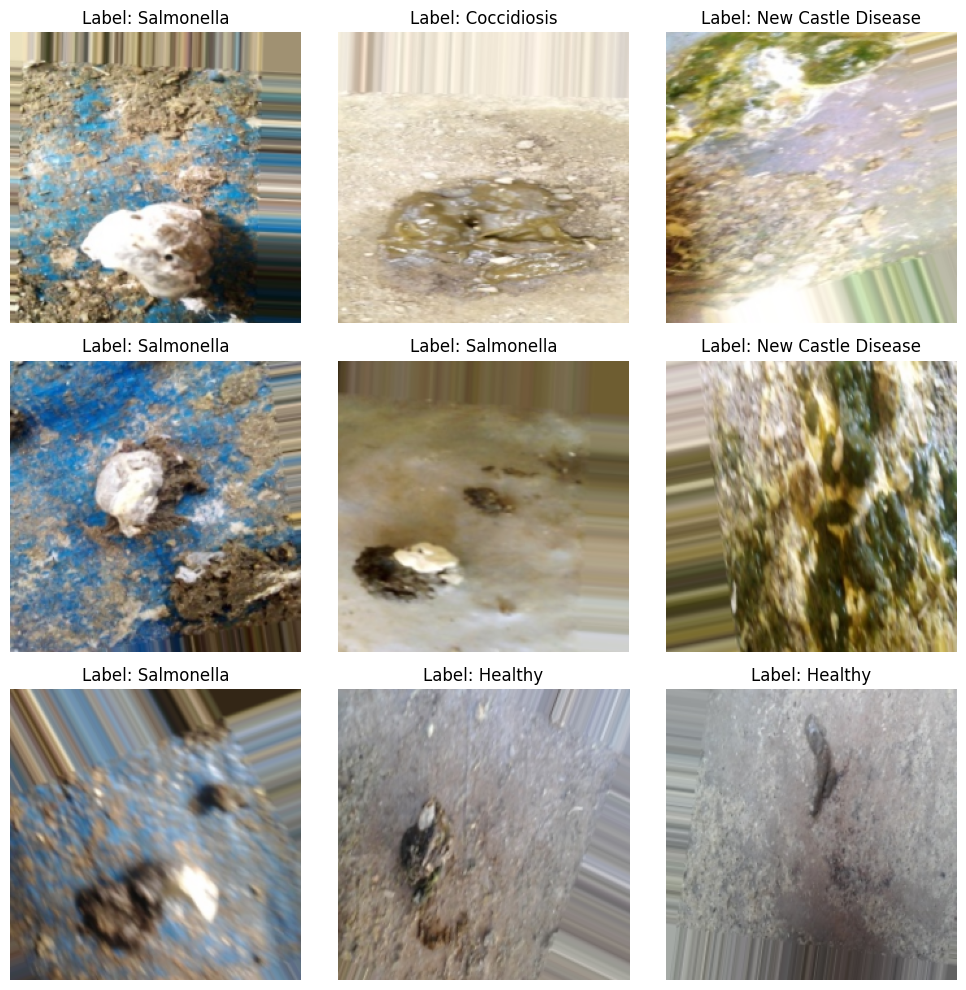

In [4]:
images, labels = next(train_generator)
label_map_inv = {v: k for k, v in train_generator.class_indices.items()} 

fig, axes = plt.subplots(3, 3, figsize=(10, 10))
axes = axes.flatten()

for img, lbl, ax in zip(images[:9], labels[:9], axes):
    label_idx = np.argmax(lbl) 
    ax.imshow(img)
    ax.set_title(f"Label: {label_map_inv[label_idx]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

# Mengecek distribusi kelas dalam dataset



In [8]:
classes = list(label_map.keys())

images = []
labels = []

for class_idx, class_name in enumerate(classes):
    class_dir = os.path.join(train_dir, class_name)
    image_files = [f for f in os.listdir(class_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

    for image_name in image_files:
        image_path = os.path.join(class_dir, image_name)
        image = cv2.imread(image_path)
        if image is not None:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
            images.append(image)
            labels.append(class_idx)


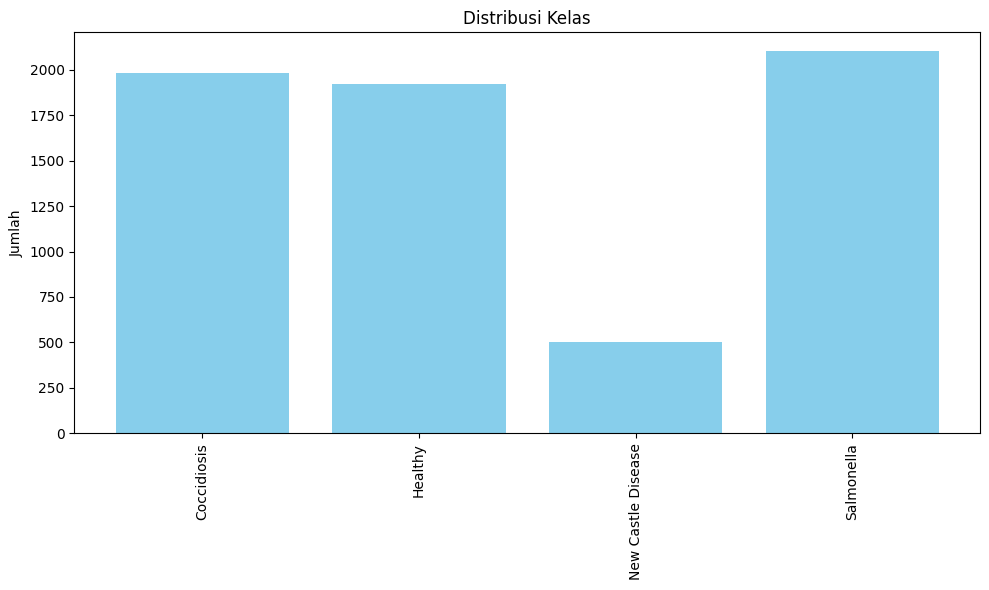

In [9]:
class_indices = np.array(labels)
class_counts = np.bincount(class_indices)

plt.figure(figsize=(10, 6))
plt.bar(classes, class_counts, color='skyblue')
plt.ylabel('Jumlah')
plt.title('Distribusi Kelas')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [10]:
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

base_model.trainable = True
for layer in base_model.layers[:100]:  
    layer.trainable = False



In [11]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
predictions = Dense(len(label_map), activation="softmax")(x)

# ini menggabungkan ke model akhir
model = Model(inputs=base_model.input, outputs=predictions)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 2,025,924 (7.73 MB)

 Non-trainable params: 396,544 (1.51 MB)

In [12]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [13]:
EPOCHS = 10  

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    verbose=1
)


c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 140s 638ms/step - accuracy: 0.7475 - loss: 0.6568 - val_accuracy: 0.8368 - val_loss: 0.4783
Epoch 2/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 125s 612ms/step - accuracy: 0.9117 - loss: 0.2475 - val_accuracy: 0.8972 - val_loss: 0.3694
Epoch 3/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 154s 757ms/step - accuracy: 0.9350 - loss: 0.1890 - val_accuracy: 0.8535 - val_loss: 0.5732
Epoch 4/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 157s 772ms/step - accuracy: 0.9415 - loss: 0.1651 - val_accuracy: 0.9293 - val_loss: 0.2660
Epoch 5/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 112s 549ms/step - accuracy: 0.9560 - loss: 0.1197 - val_accuracy: 0.9139 - val_loss: 0.3377
Epoch 6/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 112s 547ms/step - accuracy: 0.9516 - loss: 0.1372 - val_accuracy: 0.8740 - val_loss: 0.5488
Epoch 7/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 116s 568ms/step - accuracy: 0.9688 - loss: 0.0978 - val_accuracy: 0.9473 - val_loss: 0.1933
Epoch 8/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 123s 601ms/step - accuracy: 0.9619 -

In [14]:
test_lost  , test_acc = model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_acc * 100:.2f}%")

25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 399ms/step - accuracy: 0.9729 - loss: 0.1814

Test Accuracy: 95.13%


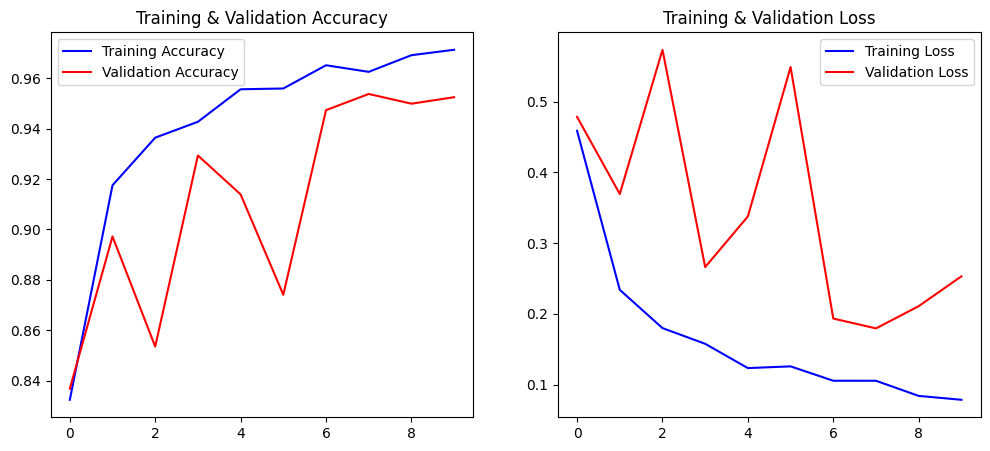

In [15]:

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(len(acc))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, "b", label="Training Accuracy")
plt.plot(epochs, val_acc, "r", label="Validation Accuracy")
plt.legend()
plt.title("Training & Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, "b", label="Training Loss")
plt.plot(epochs, val_loss, "r", label="Validation Loss")
plt.legend()
plt.title("Training & Validation Loss")

plt.show()


In [16]:
test_loss, test_acc = model.evaluate(test_generator, verbose=1)
print(f"\nTest Accuracy: {test_acc * 100:.2f}%")


25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 228ms/step - accuracy: 0.9729 - loss: 0.1814

Test Accuracy: 95.13%


In [17]:

predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

for i in range(10): 
    print(f"Image {i+1}: True Label = {class_labels[true_classes[i]]}, Predicted = {class_labels[predicted_classes[i]]}")


25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 256ms/step
Image 1: True Label = Coccidiosis, Predicted = Coccidiosis
Image 2: True Label = Coccidiosis, Predicted = Coccidiosis
Image 3: True Label = Coccidiosis, Predicted = Coccidiosis
Image 4: True Label = Coccidiosis, Predicted = Coccidiosis
Image 5: True Label = Coccidiosis, Predicted = Coccidiosis
Image 6: True Label = Coccidiosis, Predicted = Coccidiosis
Image 7: True Label = Coccidiosis, Predicted = Coccidiosis
Image 8: True Label = Coccidiosis, Predicted = Coccidiosis
Image 9: True Label = Coccidiosis, Predicted = Coccidiosis
Image 10: True Label = Coccidiosis, Predicted = Coccidiosis


In [23]:
from tensorflow.keras.preprocessing import image

img_path = "istockphoto-1220429120-1024x1024.jpg"  
img = image.load_img(img_path, target_size=IMG_SIZE)
img_array = image.img_to_array(img) / 255.0 
img_array = np.expand_dims(img_array, axis=0)  

prediction = model.predict(img_array)
predicted_class = np.argmax(prediction)
class_labels = list(test_generator.class_indices.keys())

print(f"\nPrediksi: {class_labels[predicted_class]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step

Prediksi: Salmonella


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


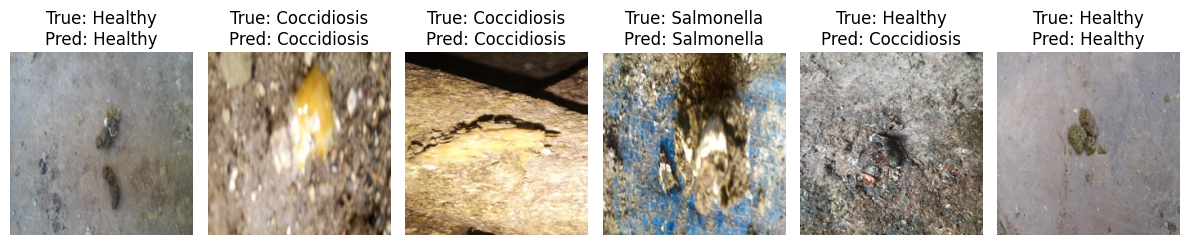

In [19]:
num_samples = 6
sample_indices = random.sample(range(len(test_generator.filenames)), num_samples)

plt.figure(figsize=(12, 6))
for i, idx in enumerate(sample_indices):
    img_path = os.path.join(test_dir, test_generator.filenames[idx])
    
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)
    true_class = test_generator.classes[idx]
    
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(img)
    plt.title(f"True: {class_labels[true_class]}\nPred: {class_labels[predicted_class]}")
    plt.axis("off")

plt.tight_layout()
plt.show()


## Deployment

In [20]:
model.save("chicken_disease_model.h5")
print("Model berhasil disimpan sebagai chicken_disease_model.h5")


Model berhasil disimpan sebagai chicken_disease_model.h5
